

###  Nettoyage et préparation du dataset Spotify





In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt


df = pd.read_csv("../dataset/spotify_dataset_popularity_balanced.csv")  # Remplacer par le dataset souhaité

###  Affichage du dataset

In [2]:

colonnes_utiles = [
    "emotion", "Tempo", "Loudness (db)", "Energy", "Danceability",
    "Positiveness", "Speechiness", "Liveness", "Acousticness", "Instrumentalness",
    "Length", "Popularity","Main_genre","text","Key","Time signature"
]
df = df[colonnes_utiles]

df.dropna(inplace=True)

print("Jeu de données nettoyé :")


Jeu de données nettoyé :


###  Entraînement et évaluation de plusieurs modèles de régression


 **Modèles testés**

   * **Régression linéaire** simple.
   * **Régression Ridge** (linéaire régularisée).
   * **Régression polynomiale** (de degré 2), qui permet de modéliser des relations non linéaires entre les variables.
   * **Random Forest Regressor**, un modèle basé sur des arbres de décision.
   * **Régression logistique**, utilisée ici non pas pour la régression mais pour la **classification binaire** : une chanson est considérée comme *populaire* si sa popularité est supérieure ou égale à 70.



In [3]:


# 1. Séparer les colonnes
cat_cols = ["Main_genre","emotion","Key","Time signature"]
num_cols = df.drop(columns=[ "Popularity"] + cat_cols).columns.tolist()

# 2. X = features, y = target
X_raw = df.drop(columns=["Popularity"])
y = df["Popularity"]

# 3. OneHotEncoding des colonnes catégorielles
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = pd.DataFrame(
    encoder.fit_transform(X_raw[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_raw.index
)

# 4. StandardScaler pour les colonnes numériques
scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(X_raw[num_cols]),
    columns=num_cols,
    index=X_raw.index
)

# 5. Fusionner
X = pd.concat([X_num, X_cat], axis=1)

# 4. Séparer les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 5. Définir les modèles
models = {
    "Régression Linéaire": LinearRegression(),
    "Régression Ridge": Ridge(alpha=1.0, solver='sag'),  # ✅ non modifié
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "Régression KNN": KNeighborsRegressor(n_neighbors=5),
}

# Ajouter automatiquement des modèles polynomiaux (degrés 2 à n)
for deg in range(2, 3):
    models[f"Régression Polynomiale (deg={deg})"] = make_pipeline(
        PolynomialFeatures(degree=deg),
        LinearRegression()
    )

# 6. Binariser la target pour la classification
y_class = (y >= 70).astype(int)

# 7. Entraîner et évaluer
for name, model in models.items():
    print(f"\n🔹 {name}")
    if "Logistique" in name:
        model.fit(X_train, y_class.loc[X_train.index])
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_class.loc[X_test.index], y_pred)
        print("Accuracy (classification binaire) :", round(acc, 3))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print("RMSE :", round(rmse, 2))
        print("R² :", round(r2, 3))


🔹 Régression Linéaire
RMSE : 24.11
R² : 0.189

🔹 Régression Ridge
RMSE : 24.11
R² : 0.189

🔹 Random Forest
RMSE : 18.07
R² : 0.545

🔹 Régression Logistique
Accuracy (classification binaire) : 0.685

🔹 Régression KNN
RMSE : 21.79
R² : 0.338

🔹 Régression Polynomiale (deg=2)
RMSE : 23.62
R² : 0.222



### Analyse des erreurs des modèles de régression

Ce bloc de code permet de visualiser les **erreurs absolues** commises par chaque modèle de régression sur les prédictions de popularité.

1. **Calcul des erreurs absolues**
   Pour chaque modèle (sauf la régression logistique), on calcule l'erreur absolue entre la valeur réelle (`y_test`) et la valeur prédite (`y_pred`) :

   $$
   \text{erreur absolue} = |y_{\text{réel}} - y_{\text{prédit}}|
   $$

2. **Affichage des histogrammes**
   Pour chaque modèle, on affiche un histogramme représentant la distribution des erreurs absolues :

   * Un histogramme centré vers **0** indique un bon modèle.
   * Une distribution étalée ou décalée vers la droite indique des erreurs plus fréquentes et importantes.

Cette visualisation permet de comparer visuellement la **précision** des modèles et d’identifier ceux qui font les prédictions les plus proches des vraies valeurs.


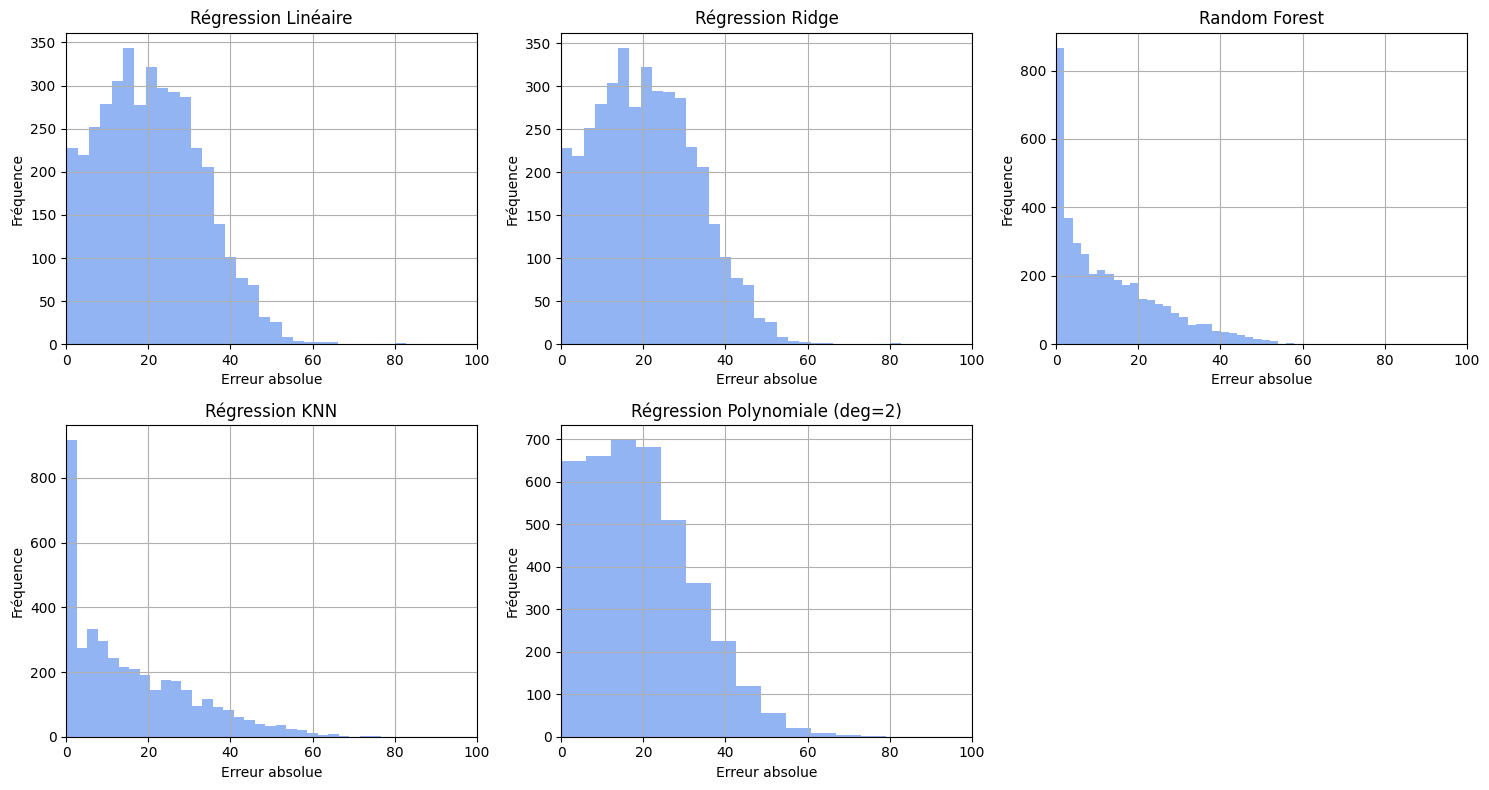

In [4]:


# Liste pour stocker les erreurs de chaque modèle
hist_data = []

for name, model in models.items():
    if "Logistique" not in name:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors = abs(y_test - y_pred)
        hist_data.append((name, errors))

# Affichage en subplots
n_models = len(hist_data)
rows = 2
cols = int(np.ceil(n_models / rows))

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, (name, errors) in enumerate(hist_data):
    axes[i].hist(errors, bins=30, color='cornflowerblue', alpha=0.7)
    axes[i].set_title(f"{name}", fontsize=12)
    axes[i].set_xlabel("Erreur absolue")
    axes[i].set_ylabel("Fréquence")
    axes[i].set_xlim(0, 100)
    axes[i].grid(True)

# Masquer les subplots vides s’il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### Régression logistique — Matrice de confusion ( classification binaire avec seuil 70 )




In [5]:
n = len(models)
acc_train = [0] * n
acc_test = [0] * n
conf_matrices = [0] * n
model_names = [""] * n

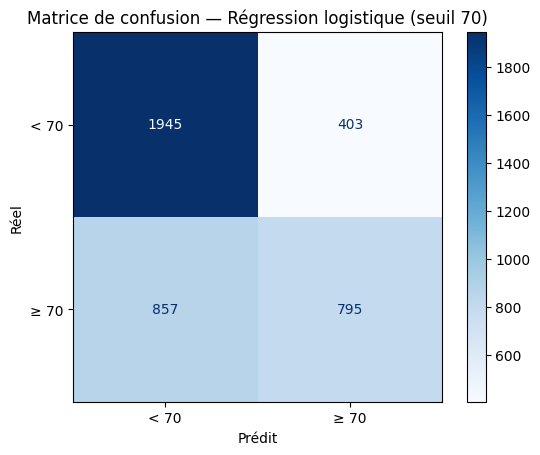

 Accuracy (seuil 70) : 0.6850


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# 1. Créer une version binaire de y avec seuil 70
y_class_70 = (y >= 70).astype(int)

# 2. Split train/test sur cette version
y_train_class70 = y_class_70.loc[X_train.index]
y_test_class70 = y_class_70.loc[X_test.index]

# 3. Entraîner le modèle logistique
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train_class70)
y_pred_class70 = log_model.predict(X_test)
y_pred_class70_train = log_model.predict(X_train)


# 4. Matrice de confusion
cm = confusion_matrix(y_test_class70, y_pred_class70)
conf_matrices[0] =cm
model_names[0] = "Régression logistique"
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["< 70", "≥ 70"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion — Régression logistique (seuil 70)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.grid(False)
plt.show()

# 5. Accuracy
acc = accuracy_score(y_test_class70, y_pred_class70)
acc_train[0] = accuracy_score(y_train_class70, y_pred_class70_train)
acc_test[0] = accuracy_score(y_test_class70, y_pred_class70)

print(f" Accuracy (seuil 70) : {acc:.4f}")


### Matrices de confusion — modèles de régression binarisés (seuil 70)


 **Évaluation via une matrice de confusion**
   Pour chaque modèle, on compare les prédictions binarisées à la vérité terrain, sous forme de matrice de confusion.
   Celle-ci permet de visualiser :

   * Les vrais positifs (bonne détection des chansons populaires)
   * Les faux positifs (chansons prédites populaires à tort)
   * Les faux négatifs (chansons populaires non détectées)
   * Les vrais négatifs


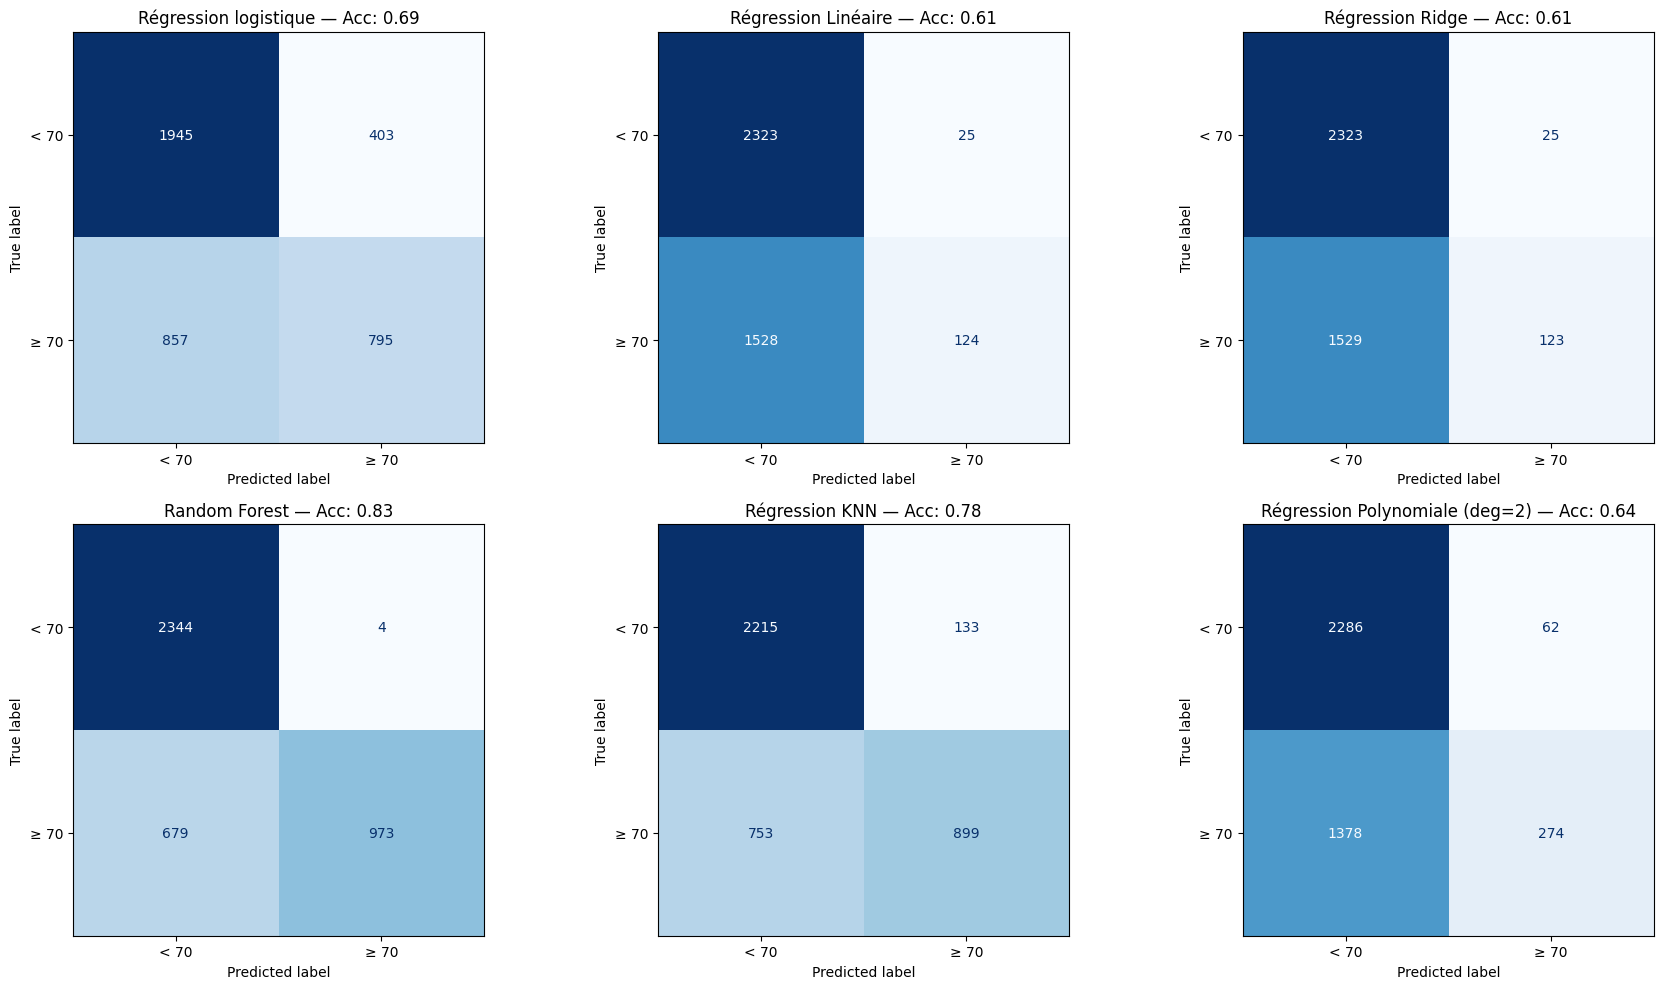

In [7]:

# Binarisation de la vérité terrain (seuil 70)
y_test_class70 = (y_test >= 70).astype(int)
y_train_class70 = (y_train >= 70).astype(int)

i=1

# Générer les prédictions et matrices de confusion
for name, model in models.items():
    if "Logistique" not in name:
        model.fit(X_train, y_train)
        y_pred_continu = model.predict(X_test)
        y_pred_continu_train = model.predict(X_train)

        y_pred_class70 = (y_pred_continu >= 70).astype(int)
        y_pred_class70_train = (y_pred_continu_train >= 70).astype(int)

        acc_train[i] = accuracy_score(y_train_class70, y_pred_class70_train)
        acc_test[i] = accuracy_score(y_test_class70, y_pred_class70)

        cm = confusion_matrix(y_test_class70, y_pred_class70)
        conf_matrices[i] =cm
        model_names[i] = name
        i+=1

# Affichage des matrices dans une seule figure (2 lignes x 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (cm, name) in enumerate(zip(conf_matrices, model_names)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["< 70", "≥ 70"])
    disp.plot(cmap="Blues", ax=axes[i], colorbar=False)
    axes[i].set_title(f"{name} — Acc: {acc_test[i]:.2f}")
    axes[i].grid(False)

plt.tight_layout()
plt.show()



### Accuracy de chaque modèle



In [8]:
print(acc_test,acc_train)
model_names = ["Régression Logistique","Régression Linéaire","Régression Ridge","Random Forest","Régression KNN","Régression Polynomiale (deg=2)"]

[0.685, 0.61175, 0.6115, 0.82925, 0.7785, 0.64] [0.6956875, 0.623, 0.623, 0.89875, 0.839125, 0.6565625]


### Comparaison Accuracy 

6 6


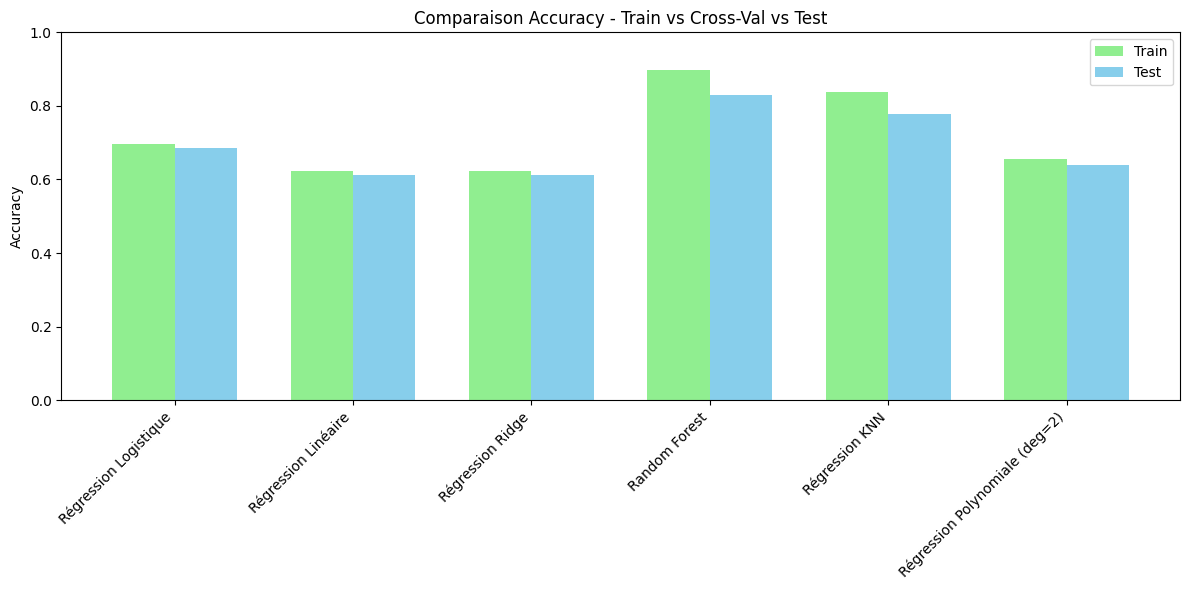

In [9]:
# Position des barres
x = np.arange(len(model_names))
width = 0.35
print(len(x),len(acc_test))
# Création du graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Barres
ax.bar(x - width/2, acc_train, width, label='Train', color='lightgreen')
ax.bar(x + width/2, acc_test, width, label='Test', color='skyblue')

# Mise en forme
ax.set_ylabel('Accuracy')
ax.set_title('Comparaison Accuracy - Train vs Cross-Val vs Test')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()


In [10]:
print(acc_test)

[0.685, 0.61175, 0.6115, 0.82925, 0.7785, 0.64]
